# Data Exploration
This notebook performs Exploratory Data Analysis (EDA) on the multi-modal survival dataset. It covers:
1. Clinical data distributions
2. Survival analysis (Kaplan-Meier)
3. Modality availability check
4. Summary statistics

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from pathlib import Path

# Add project root to path
import sys
sys.path.append('..')

# Styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded.")

Libraries loaded.


## 1. Load Clinical Data

In [3]:
# Define paths
DATA_ROOT = Path("../data/processed")
CLINICAL_PATH = DATA_ROOT / "clinical/clinical_processed.csv"

# Load data
if CLINICAL_PATH.exists():
    clinical_df = pd.read_csv(CLINICAL_PATH)
    print(f"Loaded clinical data: {clinical_df.shape}")
    display(clinical_df.head())
else:
    print(f"File not found: {CLINICAL_PATH}")
    # Try looking in splits if processed is empty (fallback)
    SPLIT_PATH = Path("../data/splits/cv_splits_flat.csv")
    if SPLIT_PATH.exists():
        print(f"Falling back to {SPLIT_PATH}")
        clinical_df = pd.read_csv(SPLIT_PATH)
        display(clinical_df.head())

Loaded clinical data: (82, 7)


,patient_id,event,time,status,gender,age,stage
0,TCGA-CV-6959,1,256.0,Dead,male,48,Stage III
1,TCGA-CV-7413,1,294.0,Dead,female,74,Stage II
2,TCGA-CR-7401,0,1077.0,Alive,male,64,Stage I
3,TCGA-CV-6433,0,641.0,Alive,male,57,Stage II
4,TCGA-CX-7082,1,11.0,Dead,male,82,Stage I


## 2. Clinical Data Distributions

Columns: ['patient_id', 'event', 'time', 'status', 'gender', 'age', 'stage']


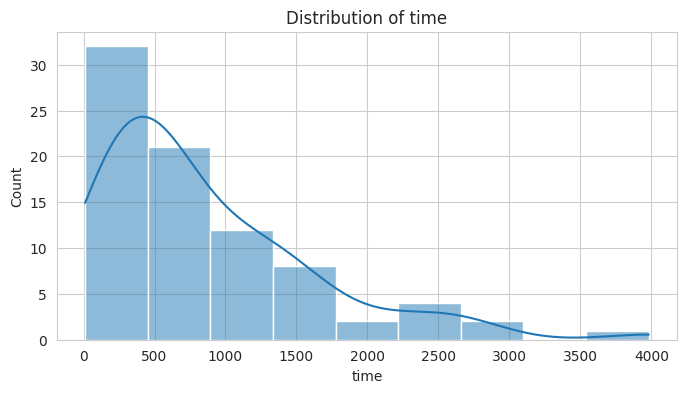

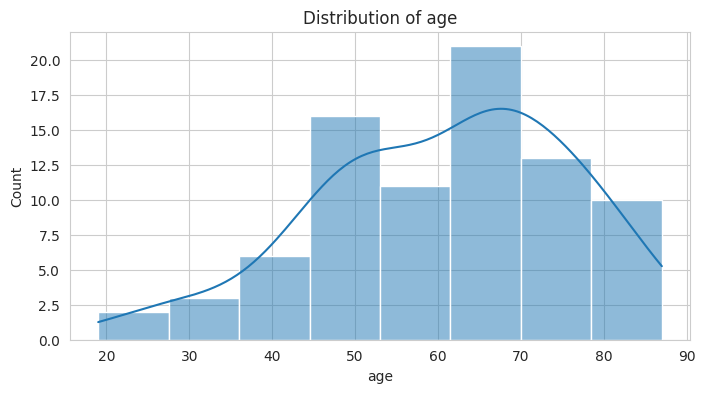

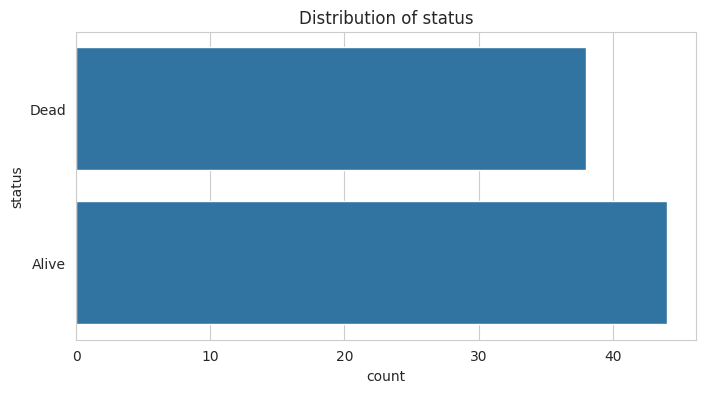

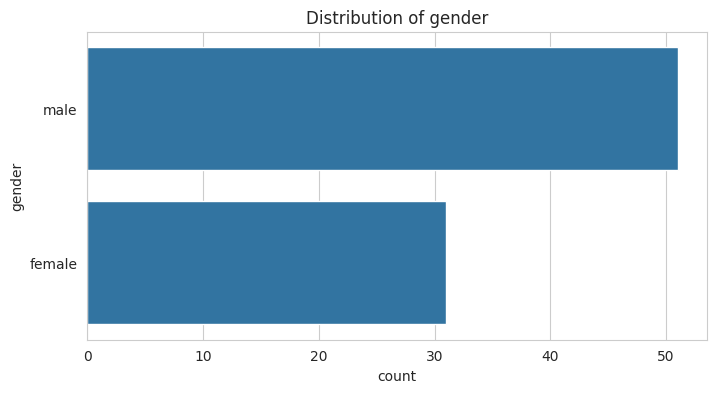

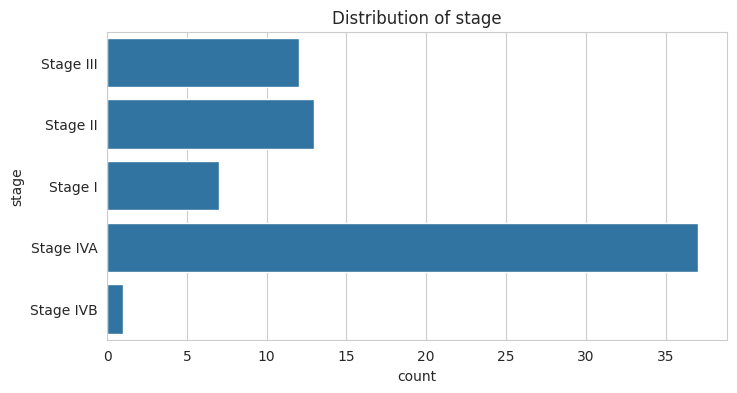

In [4]:
# Identify columns
print("Columns:", clinical_df.columns.tolist())

# Separate numerical and categorical
num_cols = clinical_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = clinical_df.select_dtypes(exclude=[np.number]).columns.tolist()

# Plot numerical
for col in num_cols:
    if 'time' in col.lower() or 'age' in col.lower(): # Basic filtering
        plt.figure(figsize=(8, 4))
        sns.histplot(clinical_df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

# Plot categorical
for col in cat_cols:
    if clinical_df[col].nunique() < 20: # Don't plot IDs
        plt.figure(figsize=(8, 4))
        sns.countplot(y=clinical_df[col])
        plt.title(f"Distribution of {col}")
        plt.show()

## 3. Survival Curves

Using time column: time, event column: event


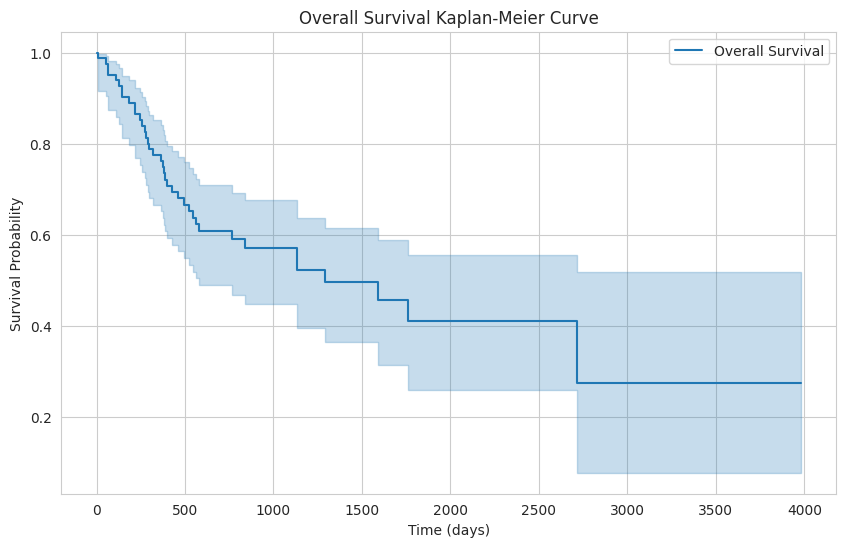

In [5]:
# Assuming 'time' and 'event' columns exist
# Adjust column names if different (e.g. 'survival_time', 'censorship')
time_col = next((c for c in clinical_df.columns if 'time' in c.lower()), None)
event_col = next((c for c in clinical_df.columns if 'event' in c.lower() or 'status' in c.lower()), None)

if time_col and event_col:
    print(f"Using time column: {time_col}, event column: {event_col}")
    kmf = KaplanMeierFitter()
    kmf.fit(clinical_df[time_col], clinical_df[event_col], label="Overall Survival")
    
    plt.figure(figsize=(10, 6))
    kmf.plot_survival_function(ci_show=True)
    plt.title("Overall Survival Kaplan-Meier Curve")
    plt.ylabel("Survival Probability")
    plt.xlabel("Time (days)")
    plt.show()
else:
    print("Could not automatically identify time or event columns.")
    print("Columns:", clinical_df.columns)

## 4. Modality Availability Check

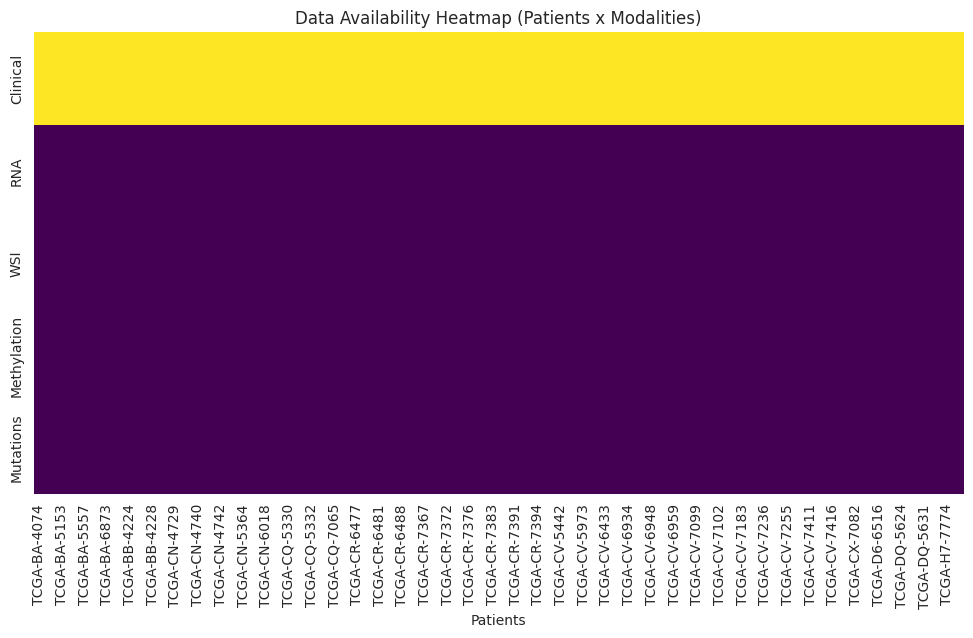

Counts:
Clinical       82
RNA             0
WSI             0
Methylation     0
Mutations       0
dtype: int64


In [6]:
def check_modality(modality_path, ext):
    if not modality_path.exists():
        return set()
    return {f.name.replace(ext, '') for f in modality_path.glob(f"*{ext}")}

# Clinical IDs
# Assuming patient_id in column 'patient_id' or index
if 'patient_id' in clinical_df.columns:
    clinical_ids = set(clinical_df['patient_id'])
elif 'bcr_patient_barcode' in clinical_df.columns:
    clinical_ids = set(clinical_df['bcr_patient_barcode'])
else:
    # Guess first column
    clinical_ids = set(clinical_df.iloc[:, 0])

# Just example extensions
rna_ids = check_modality(DATA_ROOT / "rna", ".csv")
wsi_ids = check_modality(DATA_ROOT / "wsi_features", ".pt") 
meth_ids = check_modality(DATA_ROOT / "methylation", ".csv") 
mut_ids = check_modality(DATA_ROOT / "mutations", ".csv")

# Create data frame for presence
all_ids = sorted(list(clinical_ids | rna_ids | wsi_ids | meth_ids | mut_ids))
availability = pd.DataFrame(index=all_ids)
availability['Clinical'] = availability.index.isin(clinical_ids).astype(int)
availability['RNA'] = availability.index.isin(rna_ids).astype(int)
availability['WSI'] = availability.index.isin(wsi_ids).astype(int)
availability['Methylation'] = availability.index.isin(meth_ids).astype(int)
availability['Mutations'] = availability.index.isin(mut_ids).astype(int)

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(availability.T, cmap="viridis", cbar=False)
plt.title("Data Availability Heatmap (Patients x Modalities)")
plt.xlabel("Patients")
plt.show()

print("Counts:")
print(availability.sum())

## 5. Summary Statistics

In [7]:
# Numeric summary
print("Numerical Data Summary:")
display(clinical_df.describe())

# Categorical summary
print("Categorical Data Summary:")
display(clinical_df.describe(include=['object']))

# Modality overlap counts
print("Modality Intersection Counts:")
# Only those with all modalities
all_avail = availability.all(axis=1).sum()
print(f"Patients with ALL modalities: {all_avail}")

# Only Clinical + WSI + RNA
if 'WSI' in availability and 'RNA' in availability:
    three_mod_idx = (availability['Clinical'] == 1) & (availability['WSI'] == 1) & (availability['RNA'] == 1)
    print(f"Patients with Clinical + WSI + RNA: {three_mod_idx.sum()}")

Numerical Data Summary:


,event,time,age
count,82.000000,82.000000,82.000000
mean,0.463415,851.231707,60.780488
std,0.501728,756.780662,15.311598
min,0.000000,11.000000,19.000000
25%,0.000000,298.250000,50.250000
50%,0.000000,601.500000,64.000000
75%,1.000000,1266.000000,73.000000
max,1.000000,3981.000000,87.000000


Categorical Data Summary:


,patient_id,status,gender,stage
count,82,82,82,70
unique,82,2,2,5
top,TCGA-CV-7235,Alive,male,Stage IVA
freq,1,44,51,37


Modality Intersection Counts:
Patients with ALL modalities: 0
Patients with Clinical + WSI + RNA: 0
